<a href="https://colab.research.google.com/github/juacastanori/PDI/blob/main/Proyecto/PDI_Proyecto_Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto: PDI
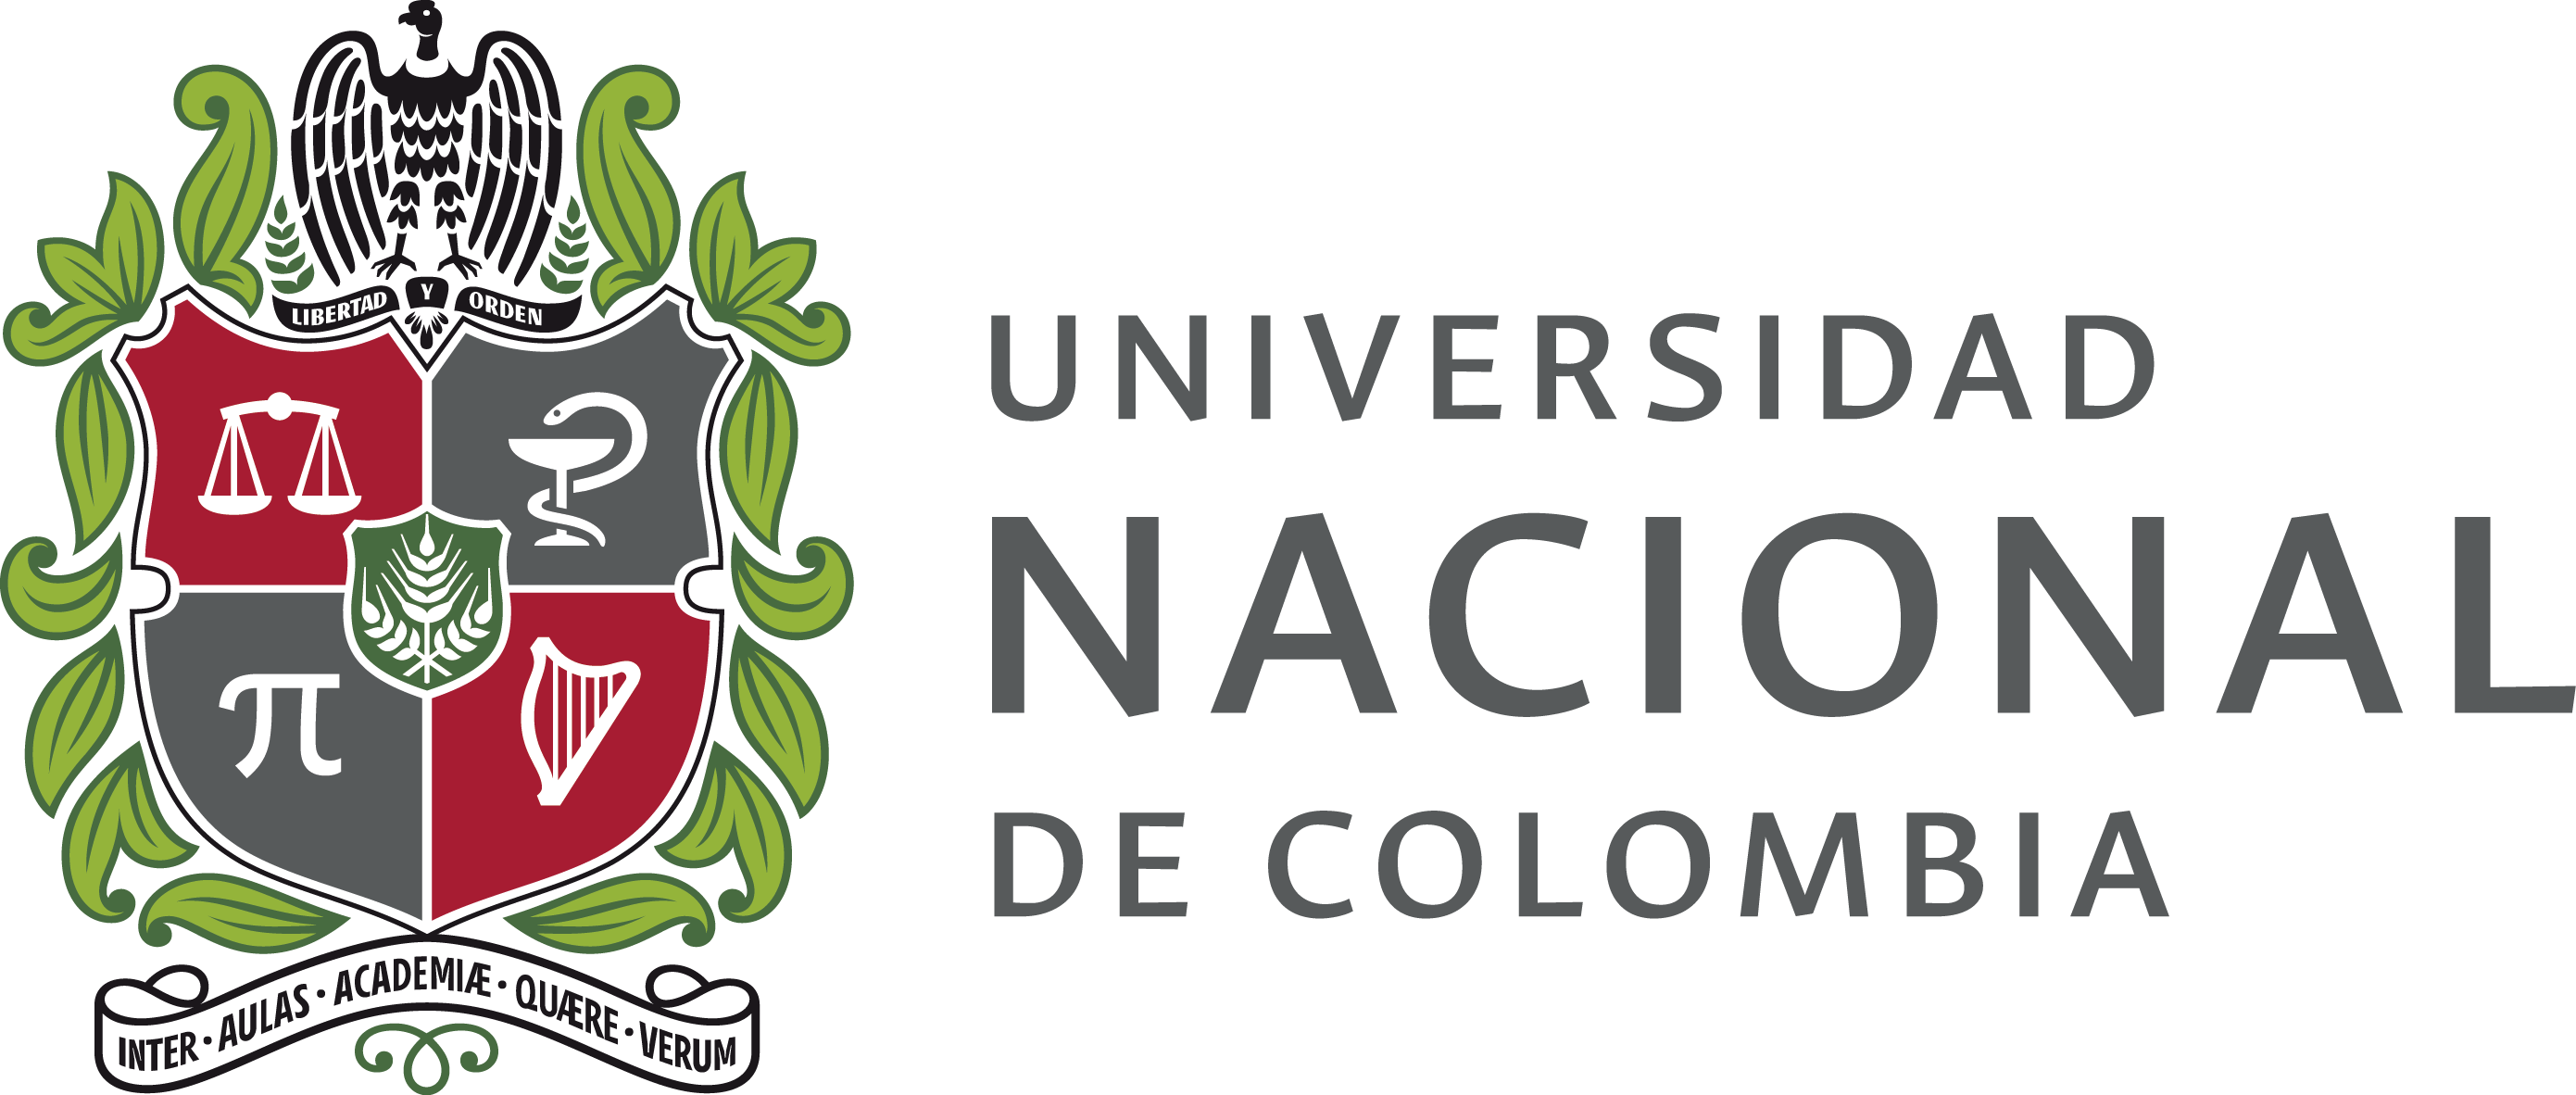
### **Universidad Nacional de Colombia sede Manizales**
#### Facultad de ingeniería y arquitectura
#### Departamento de ingeniería eléctrica, electrónica y computación
#### *Procesamiento digital de imágenes*

#### Profesor: Lucas Iturriago

# Hecho por:
## Juan Jerónimo Castaño Rivera
##Campos Herney Tulcan Cuasapud

### Despliegue en huggingface

Importo la libreria huggingface, gradio para la pagina web y git para committear

In [1]:
# CELDA A: instalar dependencias necesarias
!pip install -q huggingface_hub gradio==3.36.0 git-lfs
# No instalamos torch aquí explícitamente porque Colab ya tiene torch; si quieres una versión específica uncomment:
#!pip install -q torch torchvision

!pip install --quiet gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.9 MB/s eta 0:00:00


Hago login con la api key

In [2]:
from huggingface_hub import notebook_login
notebook_login()   # pega tu HF token cuando lo solicite (no lo compartas)


In [3]:
from huggingface_hub import HfFolder
hf_token = HfFolder.get_token()  # token guardado en sesión


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Importo el espacio del huggingface a partir del usuario y nombre del space

In [4]:
from huggingface_hub import HfFolder, Repository
import os
token = HfFolder.get_token()
HF_USER = "juacastanori"
SPACE_NAME = "plantspace"
REPO_ID = f"{HF_USER}/{SPACE_NAME}"
LOCAL_DIR = SPACE_NAME

# Clona con Repository (maneja LFS)
repo = Repository(local_dir=LOCAL_DIR, clone_from=REPO_ID, repo_type="space", use_auth_token=token)
print("Repo clonado en:", LOCAL_DIR)
print("Contenido:", os.listdir(LOCAL_DIR))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/spaces/juacastanori/plantspace into local empty directory.


Download file best.torchscript:   0%|          | 3.15k/19.6M [00:00<?, ?B/s]

Clean file best.torchscript:   0%|          | 1.00k/19.6M [00:00<?, ?B/s]

Repo clonado en: plantspace
Contenido: ['best.torchscript', 'README.md', 'app.py', 'labels.json', '.gitattributes', 'LICENSE', '.git', 'requirements.txt']


Añado las clases de plantas y creo la pagina con gradio

In [5]:
import os, json, textwrap, shutil

space_dir = "plantspace"   # LOCAL_DIR

# 1) labels.json (usa tu lista)
labels = [
    'Alo evera (SÃ¡bila)',
    'Calendula officinalis (Calendula)',
    'Chamaemelum nobile (Manzanilla)',
    'Dysphania ambrosioides (Paico)',
    'Eryngium foetidum (CimarrÃ³n)',
    'Erythroxylum coca (coca)',
    'Mentha spicata (Hierbabuena)',
    'Peumus boldus (Boldo)',
    'PlantasNoMedicinales',
    'Ruta graveolens (Ruda)',
    'Valeriana officinalis (Valeriana)'
]
os.makedirs(space_dir, exist_ok=True)
with open(os.path.join(space_dir, "labels.json"), "w", encoding="utf-8") as f:
    json.dump(labels, f, ensure_ascii=False, indent=2)

# 2) requirements.txt
req = """gradio
torch
torchvision
pillow
numpy
ultralytics
opencv-python-headless
"""
with open(os.path.join(space_dir, "requirements.txt"), "w") as f:
    f.write(req)

# 3) LICENSE (Apache-2.0 simple placeholder)
apache = "Apache-2.0"
with open(os.path.join(space_dir, "LICENSE"), "w") as f:
    f.write(apache)

# 4) app.py (Gradio app; carga TorchScript llamado best.torchscript)
app_code = r'''
import gradio as gr
from ultralytics import YOLO
from PIL import Image
import json
import os

# 1. Cargar etiquetas
with open("labels.json", "r", encoding="utf-8") as f:
    LABELS = json.load(f)

# 2. Cargar modelo usando Ultralytics
# Esto asegura que el preprocesamiento sea idéntico al entrenamiento
MODEL_FILENAME = "best.torchscript"
try:
    model = YOLO(MODEL_FILENAME, task='classify')
    print("Modelo cargado exitosamente con Ultralytics")
except Exception as e:
    print(f"Error cargando el modelo: {e}")
    model = None

def predict(img, top_k=3):
    if model is None:
        return {"Error": "Modelo no encontrado"}, "Error cargando modelo"

    # Inferencia directa con Ultralytics (hace resize y crop automático)
    results = model(img)

    # Procesar resultados
    result = results[0]
    probs = result.probs

    # Obtener Top-K
    # probs.top1 y top5 a veces difieren, así que usamos argsort manual para ser seguros con labels custom
    probs_tensor = probs.data
    top_indices = probs_tensor.argsort(descending=True)[:top_k]

    out_dict = {}
    json_output = []

    for idx in top_indices:
        i = idx.item()
        score = probs_tensor[i].item()

        # Mapeo seguro a tus etiquetas personalizadas
        if i < len(LABELS):
            label_name = LABELS[i]
        else:
            label_name = result.names[i] # Fallback a nombres internos

        out_dict[label_name] = score
        json_output.append({"label": label_name, "score": score})

    return out_dict, str(json_output)

# Interfaz Gradio
with gr.Blocks() as demo:
    gr.Markdown("# Clasificador de Plantas Medicinales")

    with gr.Row():
        with gr.Column():
            inp = gr.Image(type="pil", label="Sube una imagen")
            top_k = gr.Slider(1, 5, value=3, step=1, label="Top-K Resultados")
            btn = gr.Button("Predecir")

        with gr.Column():
            out = gr.Label(num_top_classes=3, label="Predicción")
            raw = gr.Textbox(label="Detalles JSON")

    btn.click(predict, inputs=[inp, top_k], outputs=[out, raw])

demo.launch()
'''
with open(os.path.join(space_dir, "app.py"), "w", encoding="utf-8") as f:
    f.write(app_code)

print("Archivos creados en", space_dir)
print(os.listdir(space_dir))


Archivos creados en plantspace
['best.torchscript', 'README.md', 'app.py', 'labels.json', '.gitattributes', 'LICENSE', '.git', 'requirements.txt']


Importo el modelo desde Google Drive

In [6]:
# Descargar modelos desde tu enlace de Drive
import gdown

model_ts= "1epH-Xd8A7RZfdXZN858DEUELtANaukvS"


model_ts_path= "plantspace/best.torchscript"

gdown.download(f"https://drive.google.com/uc?id={model_ts}", model_ts_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1epH-Xd8A7RZfdXZN858DEUELtANaukvS
To: /content/plantspace/best.torchscript
100%|██████████| 20.5M/20.5M [00:00<00:00, 218MB/s]


'plantspace/best.torchscript'

In [7]:
# Asumiendo que 'repo' es el Repository clonado anteriormente
# Si no lo tienes en variable, clona de nuevo:
from huggingface_hub import HfFolder, Repository
token = HfFolder.get_token()
repo = Repository(local_dir="plantspace", clone_from=f"juacastanori/plantspace", repo_type="space", use_auth_token=token)

# Track LFS (extensiones grandes)
!git lfs install
%cd plantspace
!git lfs track "*.torchscript"
!git lfs track "*.pt"
!git add .gitattributes

# Añadir todo, commitear y push
!git add -A
!git config --global user.email "juacastanori@unal.edu.co"
!git config --global user.name "juacastanori"
!git commit -m "Add Gradio app + model + labels"
!git push


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/plantspace is already a clone of https://huggingface.co/spaces/juacastanori/plantspace. Make sure you pull the latest changes with `repo.git_pull()`.


Git LFS initialized.
/content/plantspace
"*.torchscript" already supported
"*.pt" already supported
[main 5c4950d] Add Gradio app + model + labels
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 298 bytes | 298.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/juacastanori/plantspace
   ac1f655..5c4950d  main -> main


Intento hacer inferencia desde colab. No detecta la pagina web

In [ ]:
import requests, base64, json
space_url = "https://juacastanori-plantspace.hf.space/predict"  # notar el guion entre user-space
# preparar imagen (toma una de test)
test_img = "/content/original.jpg"  # ajusta a una ruta real
with open(test_img, "rb") as f:
    b64 = base64.b64encode(f.read()).decode("utf-8")
payload = {"data": [f"data:image/jpeg;base64,{b64}", 3]}
headers = {"Authorization": f"Bearer {token}"} if token else {}
r = requests.post(space_url, json=payload, headers=headers, timeout=120)
print("status:", r.status_code)
print(r.json())


status: 404
{'detail': 'Not Found'}
